In [1]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import model
from sklearn import preprocessing

device = torch.device("cuda")
print(f'Selected device: {device}')

Selected device: cuda


In [7]:
with open('../trainset_14-class.pickle', 'rb') as file:
    trainset = pickle.load(file)

spectrogram = torch.from_numpy(trainset['spectrogram'].astype(np.float32))
texture = trainset['texture']
le = preprocessing.LabelEncoder()
labels = torch.as_tensor(le.fit_transform(texture))

def Normalization(X):
    Xmin = X.min()
    Xmax = X.max()
    X_norm = (X - Xmin) / (Xmax - Xmin)
    X_norm = 2 * X_norm - 1
    return X_norm

spectrogram = Normalization(spectrogram)

train_dataset = torch.utils.data.TensorDataset(spectrogram, labels)
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = 128,
    shuffle = True,
    num_workers = 0,
    )

In [11]:
encoder = model.ResNetEncoder(feat_dim=128)

encoder_dict = torch.load('encoder_128d.pt', map_location=torch.device('cpu'))
encoder_dict = {k: v for k, v in encoder_dict.items()}
encoder.load_state_dict(encoder_dict)

generator = model.Generator(feat_dim=128)

generator_dict = torch.load('generator_128d.pt', map_location=torch.device('cpu'))
generator_dict = {k: v for k, v in generator_dict.items()}
generator.load_state_dict(generator_dict)

encoder.eval() 
encoder.to(device)
generator.eval() 
generator.to(device)

Generator(
  (resize_x): Linear(in_features=128, out_features=960, bias=True)
  (unflatten_x): Unflatten(dim=1, unflattened_size=(1, 12, 80))
  (conv_input): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), bias=False)
  (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (residual): Sequential(
    (0): _Residual_Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (in1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (relu): LeakyReLU(negative_slope=0.2, inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (1): _Residual_Block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (in1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)

In [12]:
latent_dict = {'z': [], 'label': []}

for i, (img, label) in enumerate(train_dataloader):
    img = torch.unsqueeze(img, 1) # Add channel axis (1 channel)
    img = img.to(device)
    label = label.to(torch.float32).to(device)

    z = encoder(img)

    latent_dict['z'].extend(z.detach().cpu().numpy().tolist())
    latent_dict['label'].extend(label.detach().cpu().numpy().tolist())

In [13]:
file = open('latent_dict.pickle', 'wb')
pickle.dump(latent_dict, file)
file.close()

In [14]:
from sklearn.decomposition import PCA 
import joblib

with open('latent_dict.pickle', 'rb') as file:
    latent_dict = pickle.load(file)

pca = PCA(n_components=2)	# 特征个数
pca_z = pca.fit_transform(latent_dict['z'])
# print(pca_z.min(), pca_z.max())
# joblib.dump(pca, 'PCA_z20.m')


Text(0, 0.5, '')

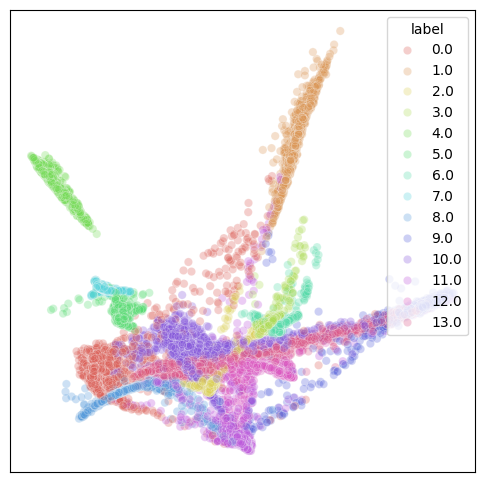

In [15]:
import seaborn as sns
import pandas as pd

plt_data = pd.DataFrame()

plt_data['pca_x'] = pca_z[:,0]
plt_data['pca_y'] = pca_z[:,1]
plt_data['label'] = latent_dict['label']

plt.figure(figsize=(6,6))
sns.scatterplot(
    x="pca_x", y="pca_y",
    hue="label",
    palette=sns.color_palette("hls", 14),
    data=plt_data,
    legend="full",
    alpha=0.3
)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

In [20]:
import umap

_umap = umap.UMAP()
umap_z = _umap.fit_transform(latent_dict['z'])

Text(0, 0.5, '')

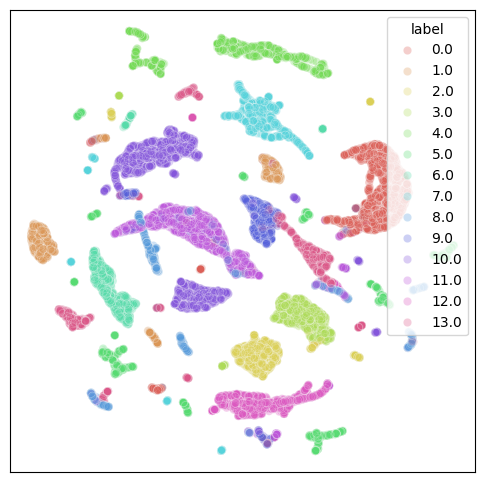

In [21]:
plt_data = pd.DataFrame()

plt_data['umap_x'] = umap_z[:,0]
plt_data['umap_y'] = umap_z[:,1]
plt_data['label'] = latent_dict['label']

plt.figure(figsize=(6,6))
sns.scatterplot(
    x="umap_x", y="umap_y",
    hue="label",
    palette=sns.color_palette("hls", 14),
    data=plt_data,
    legend="full",
    alpha=0.3
)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

In [16]:
tsne = TSNE(n_components=2, init='pca')

X = np.array(latent_dict['z'])
print(X.shape)
X_tsne = tsne.fit_transform(X)

(24480, 128)


c:\Users\zmxle\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\zmxle\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Text(0, 0.5, '')

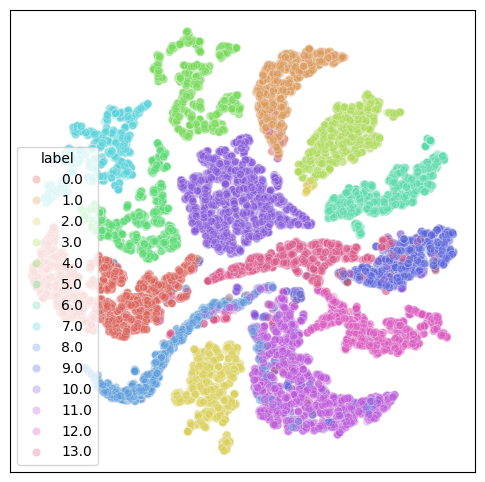

In [17]:
import seaborn as sns
import pandas as pd

plt_data = pd.DataFrame()

plt_data['tsne_x'] = X_tsne[:,0]
plt_data['tsne_y'] = X_tsne[:,1]
plt_data['label'] = latent_dict['label']

plt.figure(figsize=(6,6))
sns.scatterplot(
    x="tsne_x", y="tsne_y",
    hue="label",
    palette=sns.color_palette("hls", 14),
    data=plt_data,
    legend="full",
    alpha=0.3
)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

In [22]:
with open('../trainset_7-class.pickle', 'rb') as file:
    testset = pickle.load(file)

testset = torch.from_numpy(testset['spectrogram'].astype(np.float32))

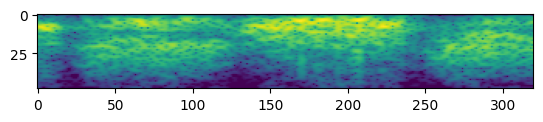

In [24]:
test_spec = spectrogram[7000]
plt.imshow(test_spec)

C:\Users\zmxle\AppData\Local\Temp\ipykernel_8504\968630327.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sss = encoder(torch.tensor(spectrogram[23000].unsqueeze(dim=0).to(device)))


tensor(-2.1043, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5068, device='cuda:0', grad_fn=<MaxBackward1>)


(-0.5, 319.5, 47.5, -0.5)

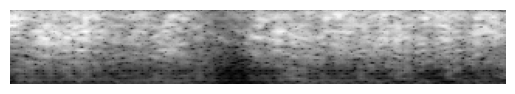

In [25]:
# re_spec = generator(encoder(torch.tensor(test_spec.unsqueeze(dim=0).to(device))))
# re_spec = generator(torch.tensor(np.random.uniform(low=-2.5, high=2.5, size=(128))).unsqueeze(dim=0).to(torch.float32).to(device))
sss = encoder(torch.tensor(spectrogram[23000].unsqueeze(dim=0).to(device)))
print(sss.min())
print(sss.max())
re_spec = generator(torch.tensor(np.random.uniform(low=-2.5, high=2.5, size=(128))).unsqueeze(dim=0).to(torch.float32).to(device))
# re_spec = generator(sss)

plt.imshow(re_spec.cpu().detach().squeeze().numpy(), cmap='gray')
plt.axis('off')

In [30]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer.add_image('Spectrogram', re_spec[0])

AttributeError: module 'PIL.Image' has no attribute 'ANTIALIAS'

In [31]:
from scipy import stats
kstest = stats.kstest(sss.squeeze().cpu().detach().numpy(), 'norm', (sss.cpu().detach().numpy().mean(), sss.cpu().detach().numpy().std()))
kstest.pvalue

0.991237111864594

In [ ]:
mean = np.array(latent_dict['z']).mean()
std = np.array(latent_dict['z']).std()
min = np.array(latent_dict['z']).min()
max = np.array(latent_dict['z']).max()

print(min)

-7.235602855682373
